In [ ]:
!pip install pyeasyga


  Preparing metadata (setup.py) ... done
  Created wheel for pyeasyga: filename=pyeasyga-0.3.1-py2.py3-none-any.whl size=6787 sha256=f1c934e8277b44e4f9b2be0b35360df7ba47972f6e65d99e7e2fb7605c7d6840
  Stored in directory: /root/.cache/pip/wheels/a7/92/a5/adeab3fb04006374ec9a017fbb3a8139643ccfd6ad83a0c85f
Successfully built pyeasyga


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive
from pyeasyga import pyeasyga

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set the path to the training and testing directories on Google Drive
train_dir = '/content/drive/MyDrive/dataset3/Training'
test_dir = '/content/drive/MyDrive/dataset3/Testing'

In [ ]:
# Set the number of classes and image dimensions
num_classes = 4
image_height, image_width = 150, 150

# Set the batch size and number of epochs
batch_size = 32
epochs = 10

In [ ]:

# Create data generators for training and testing
train_datagen = ImageDataGenerator(rescale=1.0/255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 5714 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [ ]:
# Build the CNN model for feature extraction
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(image_height, image_width, 3)
)
for layer in base_model.layers:
    layer.trainable = False


58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# Build the ANN model for classification
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Define the fitness function
def fitness_function(individual, data):
    # Set the layers of the base model as trainable based on the individual
    for i, layer in enumerate(base_model.layers):
        if i < len(individual):
            layer.trainable = individual[i]

    # Train the model
    model.fit(train_generator, steps_per_epoch=10, epochs=10, verbose=0)

    # Evaluate the model on the testing set
    _, accuracy = model.evaluate(test_generator, steps=len(test_generator), verbose=0)

    return accuracy

# Define the individual representation
def create_individual(data):
    return [np.random.choice([True, False]) for _ in range(len(data))]

# Create a genetic algorithm object
ga = pyeasyga.GeneticAlgorithm(seed_data=[], population_size=1, generations=1, crossover_probability=0.8,
                               mutation_probability=0.1, elitism=True, maximise_fitness=True)

# Set the fitness function and individual representation
ga.fitness_function = fitness_function
ga.create_individual = create_individual

# Run the genetic algorithm
ga.run()

# Get the best individual and its fitness value
best_individual = ga.best_individual()
best_fitness = best_individual[0]

print("Best Fitness:", best_fitness)
print("Best Individual:", best_individual[1])


Best Fitness: 0.8443936109542847
Best Individual: []


In [ ]:


# # Get the best fitness value
# best_accuracy = max(individual.fitness for individual in ga.population)

# # Print the best accuracy
# print("Best Accuracy:", best_accuracy)


In [ ]:
# Evaluate the model on the testing set
loss, accuracy = model.evaluate(test_generator,
                                steps=len(test_generator))
print(f'Testing Loss: {loss:.4f}')
print(f'Testing Accuracy: {accuracy:.4f}')

In [ ]:
# # Convert the best individual to a list
# best_individual_list = list(best_individual)

# # Set the layers of the base model as trainable based on the best individual
# for i, layer in enumerate(base_model.layers):
#     layer.trainable = best_individual_list[i]

# # Compile the model
# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# # Evaluate the model on the testing set
# loss, accuracy = model.evaluate(test_generator,
#                                 steps=len(test_generator))
# print(f'Testing Loss: {loss:.4f}')
# print(f'Testing Accuracy: {accuracy:.4f}')


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(test_generator.labels, y_pred)
print(cm)

In [ ]:
y_pred = model.predict(test_generator)
y_pred

In [ ]:
y_pred = np.argmax(y_pred, axis=1)
y_pred
print(y_pred)

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
#from mlxtend.plotting import plot_confusion_matrix
def clf_report(true_value, model_pred):

    classes = test_generator.class_indices.keys()
    TP_count = [true_value[i] == model_pred[i] for i in range(len(true_value))]
    model_accuracy = np.sum(TP_count)/len(TP_count)
    print('Model Accuracy', model_accuracy)

    plt.figure(figsize=(7,7))
    cm = confusion_matrix(true_value,model_pred)
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.viridis)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()*0.8
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment="center",
                color="black" if cm[i,j] > thresh else "white")
        pass

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass

    print(classification_report(true_value, model_pred, target_names = list(classes)))

In [ ]:
import cv2
from tensorflow.keras.preprocessing import image
image_path = '/content/drive/MyDrive/dataset3/Training/glioma/Te-gl_0022'
img = cv2.imread(image_path)
img = cv2.resize(img, (150, 150))
img = img / 255.0
img = np.expand_dims(img, axis=0)
predictions = model.predict(img)
class_labels = train_generator.class_indices
predicted_class = np.argmax(predictions[0])
predicted_label = list(class_labels.keys())[list(class_labels.values()).index(predicted_class)]

print("Predicted Class:", predicted_class)
print("Predicted Label:", predicted_label)



error: ignored

In [ ]:
from tensorflow.keras.models import load_model

model.save('model_cann.h5')

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('model_cann.h5')

In [ ]:
import cv2
import os
true_value = []
pred = []
i=0
for folder in os.listdir(test_dir):
    i=0
    test_image_ids = os.listdir(os.path.join(test_dir,folder))

    for image_id in test_image_ids[:int(len(test_image_ids))]:

        path = os.path.join(test_dir,folder,image_id)

        true_value.append(test_generator.class_indices[folder])
        img = cv2.resize(cv2.imread(path),(150,150))
        img_normalized = img/255

        p = np.argmax(model.predict(np.array([img_normalized])))
        pred.append(p)

1/1 [==============================] - 0s 173ms/step


In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
#from mlxtend.plotting import plot_confusion_matrix
def clf_report(true_value, model_pred):

    classes = test_generator.class_indices.keys()
    TP_count = [true_value[i] == model_pred[i] for i in range(len(true_value))]
    model_accuracy = np.sum(TP_count)/len(TP_count)
    print('Model Accuracy', model_accuracy)

    plt.figure(figsize=(7,7))
    cm = confusion_matrix(true_value,model_pred)
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.viridis)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()*0.8
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment="center",
                color="black" if cm[i,j] > thresh else "white")
        pass

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass

    print(classification_report(true_value, model_pred, target_names = list(classes)))

Model Accuracy 0.8466819221967964
              precision    recall  f1-score   support

      glioma       0.80      0.82      0.81       300
  meningioma       0.74      0.66      0.70       306
     notumor       0.90      0.97      0.93       405
   pituitary       0.92      0.89      0.91       300

    accuracy                           0.85      1311
   macro avg       0.84      0.84      0.84      1311
weighted avg       0.84      0.85      0.84      1311



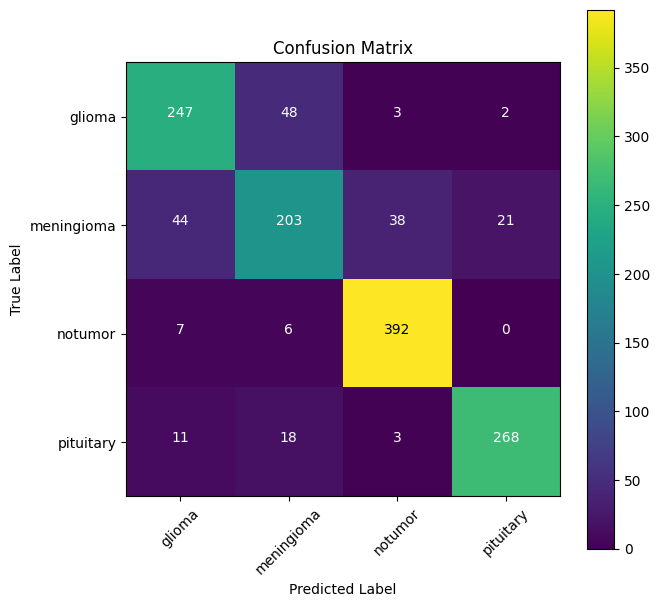

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import matplotlib.pyplot as plt
clf_report(true_value, pred)